In [1]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pandas as pd

In [2]:
df = pd.read_csv("creditcard.csv")
data = np.genfromtxt('creditcard.csv', delimiter=',')

In [3]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
np.shape(data) 

(284808, 31)

In [5]:
redata=data[1:,1:30]

In [6]:
np.shape(redata)

(284807, 29)

In [7]:
datalabel=df["Class"]

In [8]:
label=datalabel.values

In [9]:
np.shape(label)

(284807,)

In [11]:

from sklearn.model_selection import RepeatedKFold 

In [13]:


X11 = redata[label==0]
X22 = redata[label==1]


rkf = RepeatedKFold(n_splits=50, n_repeats=2, random_state=3) 

for train_index, test_index in rkf.split(X11):
    X_train1, X_test1 = X11[train_index], X11[test_index]


In [14]:
np.shape(X_test1)

(5686, 29)

In [15]:
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=5) 

In [16]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [17]:
class SVM(object):
    
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    
    def fit(self, X, y):
        n_samples, n_features = np.shape(X)
        
        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        
        P = cvxopt.matrix(np.outer(y,y) * K) # can be singular 
        
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        
        # label Vector
        
        A = cvxopt.matrix(y, (1,n_samples)) 
        
        b = cvxopt.matrix(0.0)
        
        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else: # kernel is nontrivial.
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print('{0} support vectors out of {1} points'.format(len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
    
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
        return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

The optimization problem of SVM can be rewrite as dual problem :

$\max_{\alpha} \sum_i^m \alpha_i - \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j <x^{(i)} x^{(j)}>$

Under condition : 
$\begin{aligned}
& \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
\\
 s.t. & \ \alpha_i \geq 0 
\\
&  \ \sum_i^m \alpha_i y^{(i)} = 0  
\end{aligned}$

We Implement SVM on three nonlinear kernel : Gaussian,Polynomial,Sigmoid.

The datas are very large. In particular ratio of two labeled datas is very big. 

Anyway cost time is highly required.

So we only use the data with rabel 0 about 1 percent and 8 principal component of the data.

For each kernel, we try to search suited hyperparameter.
    


The  key strategy is Random Cross validation for each step.


We select one optimal svm from 9 candidate for each kernel

In [18]:
if __name__ == "__main__":
    import matplotlib.pyplot as pl
    
    
    def gen_non_lin_separable_data():
        X22 = redata[label==1]
        
            
    
        X1 = X_test1
        X2 = X22
        y1 = np.ones(len(X_test1))
        y2 = np.ones(len(X2)) * -1
        
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2,i):
        

        rrkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=i) 


        for train_index, test_index in rrkf.split(X1):
            Xtrain1, Xtest1= X1[train_index], X1[test_index]


        for train_index, test_index in rrkf.split(X2):
            Xtrain2, Xtest2= X2[train_index], X2[test_index]



        
        
        X1_train = Xtrain1[:,:8]
        y1_train = y1[:len(Xtrain1)]
        X2_train = Xtrain2[:,:8]
        y2_train = y2[:len(Xtrain2)]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        
        X1_test = Xtest1[:,:8]
        y1_test = y1[:len(Xtest1)]
        X2_test = Xtest2[:,:8]
        y2_test = y2[:len(Xtest2)]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        
        return X_train, y_train, X_test, y_test
    
    
    
    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:100,0], X1_train[:100,1],"ro",ms=2)
        pl.plot(X2_train[:100,0], X2_train[:100,1],"bo",ms=2)
        pl.scatter(clf.sv[:100,0], clf.sv[:100,1], s=10, c="g")
        
        X1, X2 = np.meshgrid(np.linspace(-10,10,500), np.linspace(-10,10,500))
        X = np.array([[x1, x2,0,0,0,0,0,0] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z1 = clf.project(X)
        Z=Z1.reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')
        
        pl.axis("tight")
        pl.show()
    
    def test_non_linear1():
        
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        
        for i in range(1,10):


            def gaussian_kernel(x, y, sigma=i+3):
                return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

            X_train, y_train, X_test, y_test = split_train(X1, y1, X2, y2,i)




            clf = SVM(gaussian_kernel)
            clf.fit(X_train, y_train)

            y_predict = clf.predict(X_test)
            correct = np.sum(y_predict == y_test)
            print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))

        #plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)


    def test_non_linear11():
        
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        
        def gaussian_kernel(x, y, sigma=6):
                return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

        X_train, y_train, X_test, y_test = split_train(X1, y1, X2, y2,6)




        clf = SVM(gaussian_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
        
        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    #test_non_linear1()
    #test_non_linear2()
    #test_non_linear3()


$\large Set\ Optimal\ parameter\ for\ gaussian\ as\ sigma=6\ $

$\large Plotting\ 2\ principal\ component\ parts\ and\ margin(Gaussian\ kernel).$

     pcost       dcost       gap    pres   dres
 0: -3.3355e+02 -1.0972e+03  1e+04  8e+01  3e+00
 1: -1.1584e+03 -3.1834e+03  1e+04  6e+01  3e+00
 2: -4.0089e+03 -9.4922e+03  1e+04  5e+01  2e+00
 3: -8.5590e+03 -1.5693e+04  1e+04  4e+01  2e+00
 4: -1.6815e+04 -2.6165e+04  1e+04  4e+01  1e+00
 5: -3.4211e+04 -4.7006e+04  2e+04  3e+01  1e+00
 6: -8.4975e+04 -1.0453e+05  2e+04  3e+01  1e+00
 7: -1.7687e+05 -2.0707e+05  3e+04  3e+01  1e+00
 8: -4.0894e+05 -4.6275e+05  6e+04  3e+01  1e+00
 9: -7.8081e+05 -8.6882e+05  9e+04  3e+01  1e+00
10: -1.3039e+06 -1.4383e+06  1e+05  3e+01  1e+00
11: -2.5119e+06 -2.7506e+06  2e+05  3e+01  1e+00
12: -3.5629e+06 -3.8858e+06  3e+05  3e+01  1e+00
13: -6.6417e+06 -7.1978e+06  6e+05  3e+01  1e+00
14: -9.5466e+06 -1.0305e+07  8e+05  3e+01  1e+00
15: -1.3868e+07 -1.4924e+07  1e+06  3e+01  1e+00
16: -2.3347e+07 -2.5098e+07  2e+06  3e+01  1e+00
17: -3.0540e+07 -3.2900e+07  2e+06  3e+01  1e+00
18: -4.7551e+07 -5.1656e+07  4e+06  3e+01  1e+00
19: -7.0039e+07 -7.71

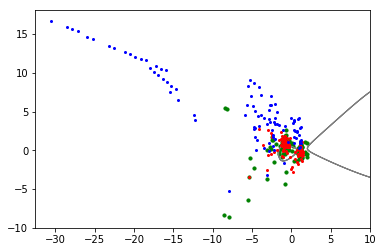

In [62]:

def test_non_linear11():

    X1, y1, X2, y2 = gen_non_lin_separable_data()

    def gaussian_kernel(x, y, sigma=6):
            return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

    X_train, y_train, X_test, y_test = split_train(X1, y1, X2, y2,6)




    clf = SVM(gaussian_kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
test_non_linear11()

In [64]:

def test_non_linear2():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    
    for i in range(1,10):


        X_train, y_train, X_test, y_test = split_train(X1, y1, X2, y2,i)

        def polynomial_kernel(x, y, p=i+1):
            return (1 + np.dot(x, y)) ** p
        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))

       # plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)\

test_non_linear2()


     pcost       dcost       gap    pres   dres
 0: -4.6762e+02 -1.4739e+03  2e+04  1e+02  3e+00
 1: -1.3954e+03 -3.7898e+03  2e+04  1e+02  3e+00
 2: -4.1897e+03 -1.0552e+04  2e+04  9e+01  3e+00
 3: -9.0326e+03 -1.8430e+04  2e+04  7e+01  2e+00
 4: -1.4842e+04 -2.7171e+04  2e+04  7e+01  2e+00
 5: -2.5503e+04 -4.0859e+04  2e+04  6e+01  2e+00
 6: -3.4088e+04 -5.2276e+04  2e+04  5e+01  2e+00
 7: -4.8159e+04 -7.0154e+04  3e+04  5e+01  1e+00
 8: -7.7840e+04 -1.0685e+05  3e+04  5e+01  1e+00
 9: -9.9471e+04 -1.3389e+05  4e+04  5e+01  1e+00
10: -2.2173e+05 -2.7498e+05  6e+04  4e+01  1e+00
11: -4.5695e+05 -5.4464e+05  9e+04  4e+01  1e+00
12: -1.3964e+06 -1.5759e+06  2e+05  4e+01  1e+00
13: -3.8942e+06 -4.2918e+06  4e+05  4e+01  1e+00
14: -9.7093e+06 -1.0562e+07  9e+05  4e+01  1e+00
15: -1.0021e+08 -1.0235e+08  2e+06  4e+01  1e+00
16: -3.1088e+09 -3.1335e+09  2e+07  4e+01  1e+00
17: -4.0998e+10 -4.1293e+10  3e+08  4e+01  1e+00
18: -4.1772e+10 -4.2073e+10  3e+08  4e+01  1e+00
19: -4.3213e+10 -4.35

ValueError: Rank(A) < p or Rank([P; A; G]) < n

when P is singular, an error is occur in CVXOPT.
As the output of the kernel is so low at high degree, it can be occured.

$\large Plotting\ 2\ principal\ component\ parts\ and\ margin(Polykernel).$


$\large Optimal\ parameter\ is\ 4$

     pcost       dcost       gap    pres   dres
 0: -2.0993e+02 -6.3507e+02  2e+04  9e+01  3e+00
 1: -8.4098e+02 -2.0382e+03  1e+04  7e+01  2e+00
 2: -2.1280e+03 -4.2305e+03  1e+04  6e+01  2e+00
 3: -3.1546e+03 -5.3692e+03  1e+04  5e+01  2e+00
 4: -5.1765e+03 -7.4599e+03  1e+04  4e+01  1e+00
 5: -8.0625e+03 -1.0276e+04  1e+04  4e+01  1e+00
 6: -1.0824e+04 -1.2953e+04  1e+04  4e+01  1e+00
 7: -1.3656e+04 -1.5557e+04  1e+04  3e+01  1e+00
 8: -1.9052e+04 -2.0189e+04  2e+04  3e+01  1e+00
 9: -2.4565e+04 -2.5451e+04  2e+04  3e+01  1e+00
10: -3.1892e+04 -3.1642e+04  2e+04  3e+01  1e+00
11: -3.2130e+04 -3.0024e+04  2e+04  3e+01  9e-01
12: -2.7959e+04 -2.2431e+04  3e+04  2e+01  8e-01
13: -1.6130e+04 -8.6478e+03  3e+04  1e+01  5e-01
14: -8.6633e+03 -3.4514e+03  2e+04  8e+00  3e-01
15: -6.0328e+03 -2.2646e+03  2e+04  6e+00  2e-01
16: -2.7718e+03 -1.1031e+03  8e+03  3e+00  1e-01
17: -1.5034e+03 -7.8071e+02  6e+03  2e+00  6e-02
18: -9.8643e+02 -6.3799e+02  4e+03  1e+00  4e-02
19: -4.5460e+02 -4.62

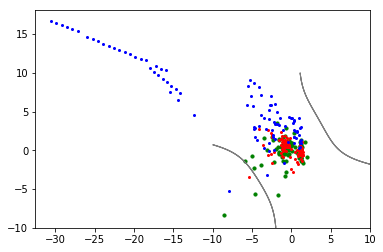

In [72]:
def test_non_linear2():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    
    for i in range(3,4):


        X_train, y_train, X_test, y_test = split_train(X1, y1, X2, y2,i)

        def polynomial_kernel(x, y, p=i+1):
            return (1 + np.dot(x, y)) ** p
        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

test_non_linear2()

$\large sigmoid\ kernel.$

In [21]:
def test_non_linear3():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    
    
    for i in range(1,10):
        X_train, y_train, X_test, y_test = split_train(X1, y1, X2, y2,i)


        def sigmoid_kernel(x1,x2,k=0.0001,theta=(-10)*i):
            return np.tanh(k*np.dot(x1,x2)+theta) 

        clf = SVM(sigmoid_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))

    #plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
    
test_non_linear3()

     pcost       dcost       gap    pres   dres
 0: -1.6308e+03 -4.6327e+03  3e+03  7e-13  3e+00
 1: -3.0763e+03 -3.1330e+03  6e+01  5e-13  1e+00
 2: -1.7136e+05 -1.7140e+05  4e+01  6e-11  1e+00
 3: -6.1499e+06 -6.1516e+06  2e+03  3e-09  1e+00
 4: -6.5241e+06 -6.5258e+06  2e+03  2e-09  1e+00
 5: -3.5220e+07 -3.5227e+07  7e+03  2e-09  1e+00
 6: -6.6807e+07 -6.6821e+07  1e+04  4e-08  1e+00
 7: -3.7489e+08 -3.7497e+08  8e+04  3e-07  1e+00
 8: -4.7712e+08 -4.7722e+08  1e+05  1e-07  1e+00
 9: -9.8653e+08 -9.8673e+08  2e+05  6e-08  1e+00
10: -3.4519e+09 -3.4526e+09  7e+05  6e-08  1e+00
11: -3.7484e+09 -3.7492e+09  8e+05  1e-06  1e+00
12: -8.7620e+09 -8.7638e+09  2e+06  5e-06  1e+00
13: -8.9256e+09 -8.9275e+09  2e+06  1e-07  1e+00
14: -2.6584e+10 -2.6589e+10  5e+06  1e-05  1e+00
15: -6.1587e+10 -6.1600e+10  1e+07  1e-05  1e+00
16: -1.0280e+11 -1.0282e+11  2e+07  8e-06  1e+00
17: -1.2948e+11 -1.2951e+11  3e+07  6e-05  1e+00
18: -2.3689e+11 -2.3694e+11  5e+07  1e-04  1e+00
19: -4.4292e+11 -4.43

I conclude Sigmoid kernels are not Inadequate.